# Exploring the rule `build_renewable_profiles`

This jupyter notebook analyses the rule `build_renewable_profiles` and its **outputs**. Outputs are timeseries of wind, csp, or solar power plants as well as the resource potential. There are two types of **potentials**: 
- technical installable power potential [MW] which does not need hourly profiles (area demand per tech. MW/km^2 * general available area m^2 * availability factor) 
- technical 'resource' energy potential [MWh] which needs hourly per unit profiles and the above power potential

This notebook looks at both.

The `build_renewable_profiles` rule, located in the `Snakefile`, explicitly list what piece of code is executed, the inputs needed to execute it, and the outputs after execution. The code of this rule is: 

```
rule build_renewable_profiles:
    input:
        natura="resources/NG/NG/NG/NG/NG/NG/" + RDIR + "natura.tiff",
        copernicus="data/copernicus/PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif",
        gebco="data/gebco/GEBCO_2021_TID.nc",
        country_shapes="resources/" + RDIR + "shapes/country_shapes.geojson",
        offshore_shapes="resources/" + RDIR + "shapes/offshore_shapes.geojson",
        hydro_capacities="data/hydro_capacities.csv",
        eia_hydro_generation="data/eia_hydro_annual_generation.csv",
        powerplants="resources/" + RDIR + "powerplants.csv",
        regions=lambda w: (
            "resources/" + RDIR + "bus_regions/regions_onshore.geojson"
            if w.technology in ("onwind", "solar", "hydro", "csp")
            else "resources/" + RDIR + "bus_regions/regions_offshore.geojson"
        ),
        cutout=lambda w: "cutouts/"
        + CDIR
        + config["renewable"][w.technology]["cutout"]
        + ".nc",
    output:
        profile="resources/" + RDIR + "renewable_profiles/profile_{technology}.nc",
    log:
    benchmark:
        "logs/" + RDIR + "build_renewable_profile_{technology}.log",
        "benchmarks/" + RDIR + "build_renewable_profiles_{technology}"
    threads: ATLITE_NPROCESSES
    resources:
        mem_mb=ATLITE_NPROCESSES * 5000,
    script:
        "scripts/build_renewable_profiles.py"
```

Observe that the script to be executed is `scripts/build_renewable_profiles.py`, which needs as inputs:

- natura raster, areas where renewables are excluded i.e. areas under protection (generated in `build_natura_raster`).
- copernicus, global land cover data (classifies land data).
- gebco, bathemetry data (deepness of sea).
- country_shapes and offshore_shapes, to determine the region of interest.
- hydro_capacities, capacities of hydro power plants.
- eia_hydro_generation, annual hydro generation from the IEA (International Energy Agency) to rescale the data if desired.
- powerplants, list of power plants.
- regions, to identify the regions that correspond to each bus.
- cutout, environmental data timeseries such as wind speed and irradiation.

and provides as ouptut `resources/renewable_profiles/profile_{technology}.nc`, where {technology} is the wildcard for which the rule is executed. It should be one of `solar`, `csp`, `onwind`, `offwind-ac`, `offwind-dc`, or `hydro`.

Before analysing the outputs of the build_renewable_profiles rule, check that:
- `pypsa-earth` environment (/kernel) in jupyter notebook is active and updated
- root folder where pypsa-earth is installed is named "pypsa-earth"
- or rename the below `sets_path_to_root("<folder_name>")` accordingly

In [22]:
# change current directory to parent folder
import os
import sys

if not os.path.isdir("pypsa-earth"):
    os.chdir("../..")
sys.path.append(os.getcwd() + "/pypsa-earth/scripts")

A jupyter notebook requires the user to import all they need. So we need to import all the required dependencies from the `pypsa-earth` environment:

In [23]:
import atlite
import cartopy.crs as ccrs
import cartopy
import xarray as xr
import geopandas as gpd

# import holoviews as hv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import pypsa
import shutil
from rasterio.plot import show
from atlite.gis import shape_availability, ExclusionContainer

import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning

warnings.filterwarnings(
    "ignore", category=ShapelyDeprecationWarning
)  # Ignore Shapely warnings

plt.rcParams["figure.figsize"] = [7, 7]
%matplotlib inline

## Generate profiles (if not already available)

If you don't have the renewable profiles such as:
- `resources/renewable_profiles/profile_solar.nc`
- `resources/renewable_profiles/profile_csp.nc`
- `resources/renewable_profiles/profile_onwind.nc`
- `resources/renewable_profiles/profile_offwind-ac.nc`

you could try to generate them from the terminal. In this case set the path so that you are located at ~/pypsa-earth. Once you are there, use the command:

```
snakemake -j 1 resources/renewable_profiles/profile_{technology}.nc
```

replace {technology} for the timeseries of interest.

## Let's open the profiles
The renewable profiles for each technology are stored in the `resources/renewable_profiles` folder. We read first the path and open then with xarray the .nc file. As you can see there is quite a lot data available.  What you should note is that only the `potential` is grided (can be shown in a nice raster on a map). From the `profiles` we can only retrieve timeseries data without mapping it.

In [24]:
solar_path = (
    os.path.realpath("pypsa-earth")
    + "/resources/Constantine/renewable_profiles/profile_solar.nc"
)
solar = xr.open_dataset(solar_path)

#csp_path = (
 #   os.path.realpath("pypsa-earth") + "/resources/Constantine/renewable_profiles/profile_csp.nc"
#)
#csp = xr.open_dataset(csp_path)

wind_path = (
    os.path.realpath("pypsa-earth")
    + "/resources/Constantine/renewable_profiles/profile_onwind.nc"
)
wind = xr.open_dataset(wind_path)
wind

<xarray.Dataset> Size: 502kB
Dimensions:           (time: 144, bus: 420, y: 9, x: 26)
Coordinates:
  * time              (time) datetime64[ns] 1kB 2013-01-01 ... 2013-01-06T23:...
  * bus               (bus) <U3 5kB '0' '2' '4' '6' ... '540' '541' '542' '543'
  * y                 (y) float64 72B 35.6 35.8 36.0 36.2 ... 36.8 37.0 37.2
  * x                 (x) float64 208B 3.0 3.2 3.4 3.6 3.8 ... 7.4 7.6 7.8 8.0
Data variables:
    profile           (time, bus) float64 484kB ...
    weight            (bus) float64 3kB ...
    p_nom_max         (bus) float64 3kB ...
    potential         (y, x) float64 2kB ...
    average_distance  (bus) float64 3kB ...

Next, we present some plots that help us understand what is in the solar and onwind renewable profiles.

### Technical installable power potential [GW]

In [25]:
def plot_raster(
    data,
    region,
    cmap="Blues",
    figsize=(10, 10),
    projection=ccrs.PlateCarree(),
    cb_label="potential",
    gridlabels=False,
    title="title",
    filename=None,
    format="pdf",
):
    # beauty therapy for plots
    font_scale = figsize[0] / 10 
    plt.rcParams.update({"font.size": 17 * font_scale})
    fig, ax = plt.subplots(figsize=figsize, subplot_kw={"projection": projection})

    # onshore potential raster
    (data / 1000).plot(
        ax=ax,
        cmap=cmap,
        edgecolor="grey",
        linestyle=":",
        add_colorbar=True,
        cbar_kwargs={"shrink": 1, "label": cb_label},
    )

    # --- FINALIZED LOCAL SHAPE FIX ---
    
    # Define the resource path relative to the pypsa-earth root folder
    resource_path = os.path.realpath("pypsa-earth") + "/resources/Constantine"
    
    # Standardize the region input
    if not isinstance(region, list):
        region = [region]
        
    try:
        # Load the country shapefile (contains the 'DZ' feature)
        shapes_country = gpd.read_file(os.path.join(resource_path, "shapes/country_shapes.geojson"))
        
        # Load the continent shapefile (contains the 'africa_shapes' feature)
        shapes_continent = gpd.read_file(os.path.join(resource_path, "shapes/africa_shapes.geojson"))
        
        # Filter shapes based on the confirmed "name" column and the input region ('DZ')
        # This handles filtering for the country shape
        if 'name' in shapes_country.columns:
            shapes = shapes_country[shapes_country['name'].isin(region)]
        else:
            # Fallback if the specific 'name' column check fails unexpectedly
            shapes = gpd.GeoDataFrame()
            print("Error: Could not find 'name' column for country filtering.")

        # Concatenate continent shapes only if "Africa" is explicitly requested in 'region' list
        # We rely on the existing files and assume 'name' or 'continent' column might hold 'Africa'
        if 'Africa' in region and 'continent' in shapes_continent.columns:
            shapes = pd.concat([shapes, shapes_continent[shapes_continent['continent'].isin(['Africa'])]])
        elif 'name' in shapes_continent.columns and 'Africa' in region:
            shapes = pd.concat([shapes, shapes_continent[shapes_continent['name'].isin(['Africa'])]])


    except Exception as e:
        print(f"FATAL ERROR: Failed to load local shapefiles. Check paths and dependencies: {e}")
        shapes = gpd.GeoDataFrame()


    # 3. Plot the boundary and set the extent
    if not shapes.empty:
        # Plot the country outline
        shapes.plot(ax=ax, edgecolor="k", color="None")

        # Set extent based on the loaded shape
        buffer = 0.5
        minx, miny, maxx, maxy = (shapes.to_crs(ccrs.PlateCarree()).bounds).values.flatten()
        minx, miny = [minx - buffer, miny - buffer]
        maxx, maxy = [maxx + buffer, maxy + buffer]
        ax.set_extent([minx, maxx, miny, maxy], crs=ccrs.PlateCarree())
    else:
        # Fallback for "Constantine" region extent if loading/filtering fails
        print("Using hardcoded extent for Northern Algeria due to shapefile error.")
        ax.set_extent([1.5, 9.0, 34.0, 38.0], crs=ccrs.PlateCarree()) 

    # --- END FINALIZED FIX ---

    if gridlabels == True:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
        gl.top_labels = False
        gl.right_labels = False
        gl.xlines = False
        gl.ylines = False
        gl.xlabel_style = {"size": 12 * font_scale}
        gl.ylabel_style = {"size": 12 * font_scale}

    if title is not None:
        plt.title(title)

    if filename is not None:
        plt.savefig(filename, bbox_inches="tight")
        
    plt.show()

c:\Users\Administrator\miniconda3\envs\pypsa-earth\Lib\site-packages\pyogrio\__init__.py:7: DeprecationWarning: The 'shapely.geos' module is deprecated, and will be removed in a future version. All attributes of 'shapely.geos' are available directly from the top-level 'shapely' namespace (since shapely 2.0.0).
  import shapely.geos  # noqa: F401


FATAL ERROR: Failed to load local shapefiles. Check paths and dependencies: C:\Users\Administrator\Desktop\Pypsa\pypsa-earth/resources/Constantine\shapes/africa_shapes.geojson: No such file or directory
Using hardcoded extent for Northern Algeria due to shapefile error.


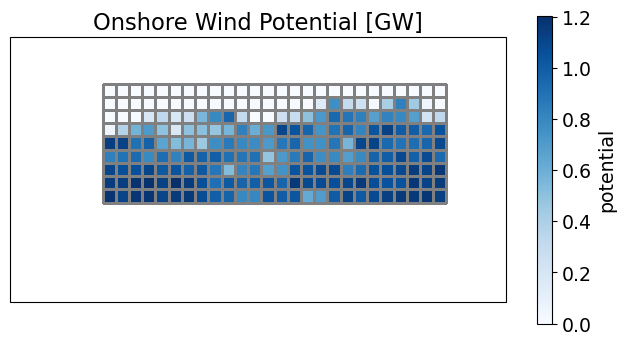

In [26]:
plot_raster(
    wind.potential,
    ["Nigeria"],
    cmap="Blues",
    figsize=(8, 4),
    projection=ccrs.PlateCarree(),
    cb_label="potential",
    gridlabels=False,
    title="Onshore Wind Potential [GW]",
    # filename="rasterized-onshore-wind-potential.pdf"
)

FATAL ERROR: Failed to load local shapefiles. Check paths and dependencies: C:\Users\Administrator\Desktop\Pypsa\pypsa-earth/resources/Constantine\shapes/africa_shapes.geojson: No such file or directory
Using hardcoded extent for Northern Algeria due to shapefile error.


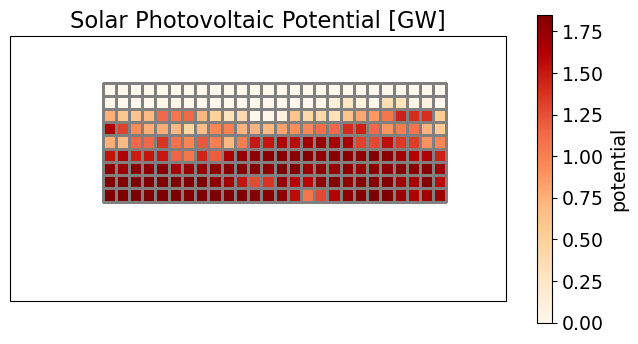

In [27]:
plot_raster(
    solar.potential,
    ["DZ"],
    cmap="OrRd",
    figsize=(8, 4),
    projection=ccrs.PlateCarree(),
    cb_label="potential",
    gridlabels=False,
    title="Solar Photovoltaic Potential [GW]",
    # filename="rasterized-solvar-pv-potential.pdf"
)

### Technical installable potential in bus regions. Provided by Fabian Neumann.

In [28]:
def plot_map(data, cmap, projection, voronoi=None, title=None, filename=None):
    plt.rcParams.update({"font.size": 12})
    fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={"projection": projection})
    data.plot.imshow(
        ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, label="potential [MW]"
    )
    # contourf
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS.with_scale("110m"))
    ax.set_extent([3, 8, 35.5, 37.5], crs=ccrs.PlateCarree())  # Nigeria
    #  ax.set_extent([-23, 55, -35, 40], crs=ccrs.PlateCarree())  # Africa
    resource_path = os.path.realpath("pypsa-earth/resources/Constantine")
    if voronoi == "onshore":
        br = gpd.read_file(f"{resource_path}/bus_regions/regions_{voronoi}.geojson")
        br.plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            facecolor="none",
            linewidth=0.25,
            edgecolor="k",
        )
    elif voronoi == "offshore":
        br = gpd.read_file(f"{resource_path}/bus_regions/regions_{voronoi}.geojson")
        br.plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            facecolor="none",
            linewidth=0.25,
            edgecolor="k",
        )

    if title is not None:
        plt.title(title)

    if filename is not None:
        plt.savefig(filename, bbox_inches="tight")

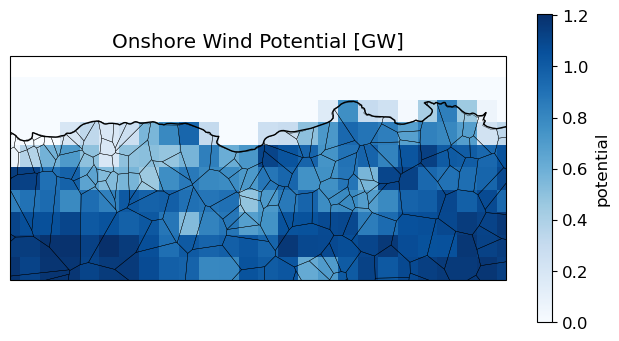

In [29]:
plot_map(
    wind.potential / 1000,
    "Blues",
    ccrs.PlateCarree(),
    voronoi="onshore",
    title="Onshore Wind Potential [GW]",
    # filename="onwind-gridcell.pdf",
)

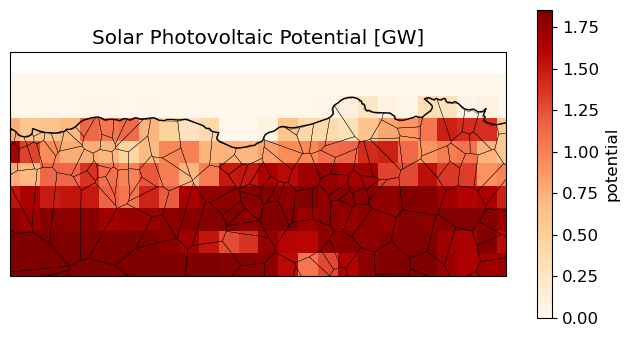

In [30]:
plot_map(
    solar.potential / 1000,
    "OrRd",
    ccrs.PlateCarree(),
    voronoi="onshore",
    title="Solar Photovoltaic Potential [GW]",
    # filename="solar-gridcell.pdf",
)

In [31]:
#plot_map(
    #csp.potential / 1000,
    #"Greens",
    #ccrs.PlateCarree(),
    #voronoi="onshore",
    #title="CSP Photovoltaic Potential [GW]",
    # filename="csp-gridcell.pdf",
#)

In [32]:
resource_path = os.path.realpath("pypsa-earth/resources/Constantine")
network_path = os.path.realpath("pypsa-earth/networks/Constantine")
br = gpd.read_file(f"{resource_path}/bus_regions/regions_onshore.geojson")
elec = pypsa.Network(f"{network_path}/elec.nc")

Index(['transf_0_0', 'transf_1_0', 'transf_2_0', 'transf_4_0', 'transf_5_0',
       'transf_5_1', 'transf_6_0', 'transf_6_1', 'transf_7_0', 'transf_8_0',
       ...
       'transf_246_0', 'transf_259_0', 'transf_282_0', 'transf_304_0',
       'transf_306_0', 'transf_309_0', 'transf_309_1', 'transf_323_0',
       'transf_327_0', 'transf_344_0'],
      dtype='object', name='name', length=124)
Index(['transf_0_0', 'transf_1_0', 'transf_2_0', 'transf_4_0', 'transf_5_0',
       'transf_5_1', 'transf_6_0', 'transf_6_1', 'transf_7_0', 'transf_8_0',
       ...
       'transf_246_0', 'transf_259_0', 'transf_282_0', 'transf_304_0',
       'transf_306_0', 'transf_309_0', 'transf_309_1', 'transf_323_0',
       'transf_327_0', 'transf_344_0'],
      dtype='object', name='name', length=124)
Index(['transf_0_0', 'transf_1_0', 'transf_2_0', 'transf_4_0', 'transf_5_0',
       'transf_5_1', 'transf_6_0', 'transf_6_1', 'transf_7_0', 'transf_8_0',
       ...
       'transf_246_0', 'transf_259_0', 'transf_

In [33]:
def plot_voronoi(n, carrier, voronoi, cmap, projection, title=None, filename=None):

    g = n.generators.loc[n.generators.carrier == carrier]
    br = gpd.read_file(
        f"pypsa-earth/resources/Constantine/bus_regions/regions_{voronoi}.geojson"
    ).set_index("name")
    br_area = br.to_crs("ESRI:54009")
    br_area = br_area.geometry.area * 1e-6
    br["p_nom_max"] = g.groupby("bus").sum().p_nom_max / br_area

    fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={"projection": projection})
    plt.rcParams.update({"font.size": 10})
    br.plot(
        ax=ax,
        column="p_nom_max",
        transform=ccrs.PlateCarree(),
        linewidth=0.25,
        edgecolor="k",
        cmap=cmap,
        vmin=0,
        vmax=br["p_nom_max"].max(),
        legend=True,
        legend_kwds={"label": r"potential density"},
    )
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS.with_scale("110m"))
    ax.set_extent([3, 8, 35.5, 37.5], crs=ccrs.PlateCarree())  # Nigeria
    #  ax.set_extent([-23, 55, -35, 40], crs=ccrs.PlateCarree())  # Africa

    if title is not None:
        plt.title(title)

    if filename is not None:
        plt.savefig(filename, bbox_inches="tight")

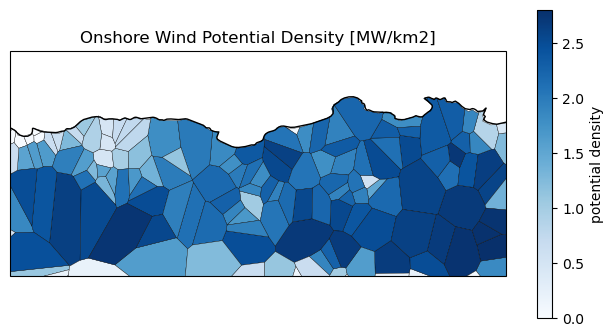

In [34]:
plot_voronoi(
    elec,
    "onwind",
    "onshore",
    "Blues",
    ccrs.PlateCarree(),
    title="Onshore Wind Potential Density [MW/km2]",
    # filename="onwind-cell.pdf",
)

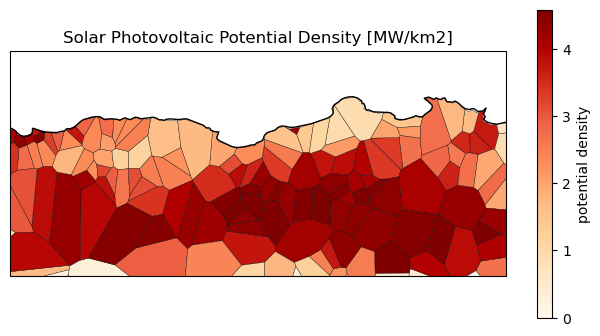

In [35]:
plot_voronoi(
    elec,
    "solar",
    "onshore",
    "OrRd",
    ccrs.PlateCarree(),
    title="Solar Photovoltaic Potential Density [MW/km2]",
    # filename="solar-cell.pdf",
)

The CSP plot is quite similar to the Solar plot, both of which were created using the default configuration in the pypsa-earth repository.

In [ ]:
plot_voronoi(
    elec,
    "csp",
    "onshore",
    "Greens",
    ccrs.PlateCarree(),
    title="CSP Potential Density [MW/km2]",
    # filename="csp-cell.pdf",
)

### Technical 'resource' energy potential [TWh]

In [ ]:
technical_solar_potential_twh = (
    sum(solar["p_nom_max"] * solar["profile"]).sum() / 10**6
)  # MWh to TWH conversion
technical_wind_potential_twh = (
    sum(wind["p_nom_max"] * wind["profile"]).sum() / 10**6
)  # MWh to TWH conversion
#technical_csp_potential_twh = sum(csp["p_nom_max"] * csp["profile"]).sum() / 10**6  #

print(
    f"Technical solar potential: {technical_solar_potential_twh.values} \n",
    #f"Technical csp potential: {technical_csp_potential_twh.values} \n",
    f"Technical wind potential: {technical_wind_potential_twh.values}",
)

Technical solar potential: 3.747711066758356 
 Technical wind potential: 1.3239491995998953


## Timeseries
Timeseris plots are helpful to analyse the seasonality and general variability. Below we show how you could plot some of these.

Text(0.5, 1.0, '')

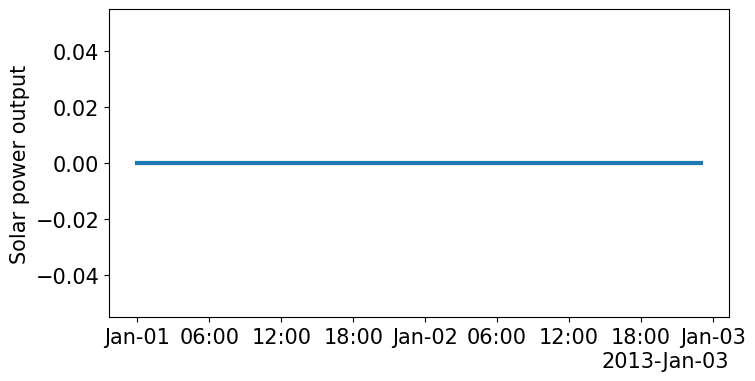

In [ ]:
plt.rcParams.update({"font.size": 15})
fig, ax = plt.subplots(figsize=(8, 4))

# max_installable_capacity [MX] * profiles [p.u.]
solar_profile_mw = solar["p_nom_max"] * solar["profile"]

solar_profile_mw.sel(bus="0", time=slice("2013-01-01", "2013-01-02")).plot(
    ax=ax, linewidth=3
)
ax.set_xlabel(None)
ax.set_ylabel("Solar power output")
ax.set_title(None)

# plt.savefig("solar-power-profile.pdf", bbox_inches="tight")

In [ ]:
plt.rcParams.update({"font.size": 10})
solar["profile"].isel(bus=sum(range(8)), time=range(0, 1000)).plot()
plt.show()

IndexError: index 144 is out of bounds for axis 0 with size 144

## Build Renewable Profiles for Hydro

In this section, we describe how hydro renewable profiles are obtained and introduced into the model. This is done with the rule `build_renewable_profiles`, but the hydro renewable profiles are obtained differently than the solar, onwind, onffwind-ac, and offwind-dc renewable profiles. 

This is because wind and solar are local resources, i.e., their instanteneous power generation depends only on the solar irradiation and wind speed around the solar panels and wind turbines, respectively. By contrast, the water availability for hydro power plants depends on rainfall from a large area, often far away from the actual hydro power plant. To capture this feature, pypsa-earth considers the river basins associated to all hydro power plants in the region of interest. This often enlarges the geographical area that needs to be considered beyond the region of interest.

### Generate Hydro Profiles

The instruction to generate the hydro profile is analogous to those to generate solar, onwind, offwind-ac, and offwind-dc profiles. To generate them from the terminal, set the path to `~/pypsa-earth` and use the command:

```
snakemake -j 1 resources/renewable_profiles/profile_hydro.nc
```

This generates the file `resources/renewable_profiles/profile_hydro.nc`, which contains the hydro profile in xarray format.

### Let's Open The Hydro Profiles

The hydro profile has been stored in `resources/renewable_profiles/profile_hydro.nc`. As for the solar and wind profiles, the .nc file can be opened with xarray after we indicate the right path:

In [ ]:
hydro_path = (
    os.path.realpath("pypsa-earth")
    + "/resources/NG/renewable_profiles/profile_hydro.nc"
)
hydro = xr.open_dataset(hydro_path)
hydro

<xarray.Dataset>
Dimensions:  (plant: 159, time: 8760)
Coordinates:
  * plant    (plant) <U3 '0' '2' '4' '5' '7' ... '198' '199' '200' '201' '202'
  * time     (time) datetime64[ns] 2013-01-01 ... 2013-12-31T23:00:00
Data variables:
    inflow   (plant, time) float64 ...

Observe that there is one variable only, `inflow`, which is indexed by `plant` and `time`. This is an hourly time series of water inflows (in MWh) for every hydro power plant. 

Note the contrast with solar, csp and wind profiles: the xarray of hydro profiles is not indexed by coordinates and, in particular, cannot be plotted directly into a map.

### Some Plots (More Time Series)

Given the structure of the hydro profiles, we can represent the hourly inflows in one plant: 

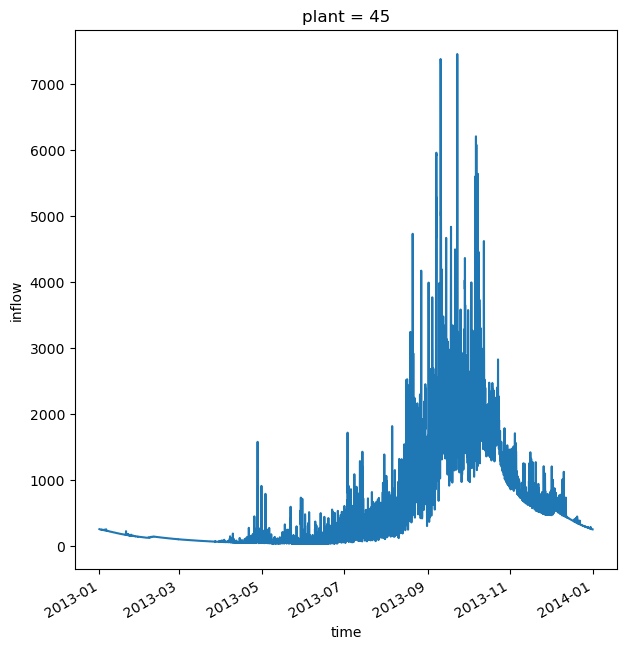

In [ ]:
hydro_plant = hydro.sel(plant="45")
hydro_plant.inflow.plot.line(x="time")

and we can also zoom in a specific time period:

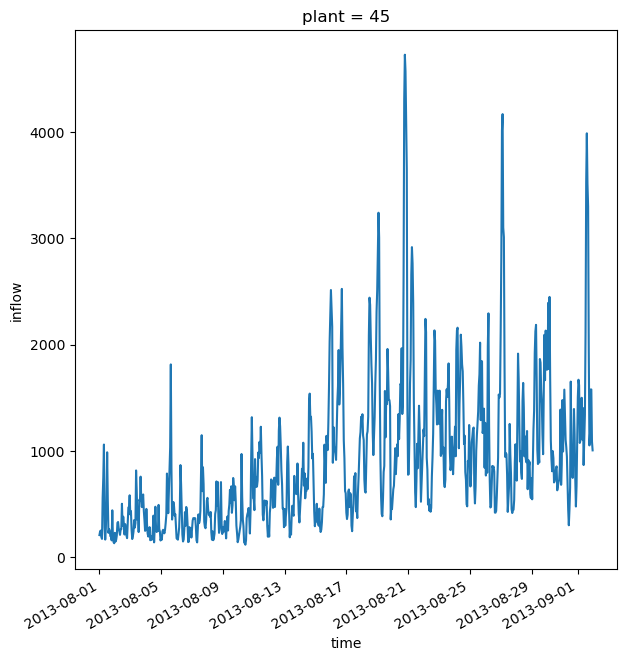

In [ ]:
hydro_plant_aug = hydro.sel(plant="45", time=slice("2013-08-01", "2013-09-01"))
hydro_plant_aug.inflow.plot.line(x="time")

### What Happens behind the Scenes of Hydro Modelling?

The modelling to obtain the water inflows at every power plant can be divided in three steps:

1. Obtaining data from ERA5 dataset.
2. Data processing to capture catchment basins with atlite.
2. Normalization to match country statistics.
3. Add hydro types to electricity network.

Technically speaking, the rule build_renewable_profiles takes care of steps 1, 2, and 3. Step 4 is done in the rule add_electricity, but it still constitutes an important part of how hydro is modelled in pypsa-earth.

#### 1. Obtaining Data from ERA5 dataset

The [ERA5 dataset](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview) is a detailed global climate and weather model of the last 8 decades. It divides the earth into small cells, and provides hourly data of many climate and weather indicators for each cell. The ERA5 dataset is obtained from a reanalysis model. This model sequentially combines model data with observations from accross the world into a globally complete and consistent dataset using the laws of physics.

From the ERA5 dataset, pypsa-earth obtains the surface runoff. This is the water from rainfall and melting snow that drains away over the surface. The unit for surface runoff is depth in metres of water, which is the depth water would have if it was spread evenly over the grid box (in meters).

The ERA5 dataset is the default data source, but others can be used.

#### 2. Data Processing to Capture Catchment Basins with Atlite

To obtain the water inflow in a hydro power plant, we need to consider the catchment basin of that plant. The [atlite](https://atlite.readthedocs.io/en/latest/introduction.html) package obtains the inflow time series every hydro plant recieves.

 It is done by aggregating over catchment basins (`hydrobasin` in atlite). For every hydro power plant, atlite aggregates the water in the corresponding hydrobasin that is upstream from the hydro power plant. The atlite function [hydro](https://atlite.readthedocs.io/en/latest/ref_api.html#atlite.Cutout.hydro) is the main tool for doing this: it is here where the catchment basins associated to all hydro power plants in the region of interest are considered.

#### 3. Normalization to Match Country Statistics

The inflow time series above is expressed in depth in meters of water, which is not a unit that can be used by a hydro power plant. To express the inflows in MWh-equivalent, and to ensure that the data is consistent with external sources, a normalization procedure is implemented. This uses total hydro inflows in the region of interest from an external source of your choice (in MWh). It then rescales the inflows obtained in step 1, so that the total inflows from step 1 and the independent source coincide. This ensures that the inflows obtained are in MWh and are consistent with independent data, while preserving the spatial distribution obtained in step 1.

The normalization is controlled by the flag `[renewable][hydro][normalization][method]` in the config.yaml file. Note that it can be turned off with the option `False`, which might result in meaningless results due to not using the correct units.

#### 4. Add Hydro Types to Electricity Network

In the rule `add_electricity`, the renewable profiles created for every hydro power plant are added to the corresponding bus in the network. This is done for every hydro type:

1. runoff river (`ror`)
2. hydro dam (`hydro`)
3. pumped hydro storage (`PHS`).

In fact, the rule `add_electricity` does much more than that. It also adds the renewable profiles of the other renewable technologies (solar and wind), the operational parameters of every power plant, and the load at every time step. For more details on this rule, see the notebook `add_electricity.ipynb`.

The resulting network is stored in `networks/elec.nc`.